# Wind statistics

Fig. 3 from Moore-Maley and Allen, 2021, Ocean Sci.:

Hourly wind observations and HRDPS results for the 2015-2019 period at Sentry Shoal, Sisters Islet, Halibut Bank and Sand Heads.

***

In [1]:
import numpy as np
import xarray as xr
import requests
from pandas import read_csv
from datetime import datetime
from io import BytesIO
from xml.etree import cElementTree as ElementTree
from matplotlib import pyplot as plt
from windrose import WindroseAxes
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Functions for loading data

In [3]:
def load_HRDPS(HRDPS, j, i, timerange):
    """Load HRDPS model results from salishsea.eos.ubc.ca/erddap
    """

    # Extract velocities from ERDDAP and calculate wspd, wdir
    tslc = slice(*timerange)
    u, v = [HRDPS.sel(time=tslc)[var][:, j, i].values for var in ('u_wind', 'v_wind')]
    time = HRDPS.sel(time=tslc).time.values.astype('datetime64[s]').astype(datetime)
    wspd = np.sqrt(u**2 + v**2)
    wdir = np.rad2deg(np.arctan2(v, u))
    
    # Transform wdir to degrees FROM, CW from N
    wdir = 270 - wdir
    wdir[wdir < 0] = wdir[wdir < 0] + 360
    
    return time, wspd, wdir


def load_EC(ID, year, month):
    """Load EC met station data from climate.weather.gc.ca
    """

    # Submit query
    url = 'http://climate.weather.gc.ca/climate_data/bulk_data_e.html'
    query = {
        'timeframe': 1,
        'stationID': ID,
        'format': 'xml',
        'time': 'UTC',
        'Year': year,
        'Month': month,
        'Day': 1,
    }
    response = requests.get(url, params=query)
    tree = ElementTree.parse(BytesIO(response.content))
    root = tree.getroot()

    # Extract data
    time, wspd, wdir, values = [], [], [], {}
    for record in root.findall('stationdata'):
        for var in ('windspd', 'winddir'):
            try:
                values[var] = float(record.find(var).text)
            except:
                break
        else:
            dateargs = [int(record.get(field)) for field in ('year', 'month', 'day', 'hour')]
            time.append(datetime(*dateargs))
            wspd.append(values['windspd'])
            wdir.append(values['winddir'])
    
    # Convert lists to arrays
    time = np.array(time)
    wspd = np.array(wspd) / 3.6  # km/h to m/s
    wdir = np.array(wdir) * 10   # tens of degrees to degrees
    
    return time, wspd, wdir


def load_DFO(ID):
    """Load DFO wave buoy data from www.meds-sdmm.dfo-mpo.gc.ca
    """

    # Extract data from csv link
    fn = f'https://www.meds-sdmm.dfo-mpo.gc.ca/alphapro/wave/waveshare/csvData/c{ID}_csv.zip'
    df = read_csv(fn, index_col='DATE', parse_dates=True)
    time = df.index.values.astype('datetime64[s]').astype(datetime)
    wspd, wdir = [df[var].values for var in ('WSPD', 'WDIR')]
    
    return time, wspd, wdir

***

### Load data

Definitions

In [4]:
# Station attributes
stations = {
    'Sentry Shoal' : {'ID': 46131, 'ji': (183, 107)},
    'Sisters Islet': {'ID':  6813, 'ji': (160, 120)},
    'Halibut Bank' : {'ID': 46146, 'ji': (149, 141)},
    'Sand Heads'   : {'ID':  6831, 'ji': (135, 151)},
}

# Assign HRDPS as netcdf object from erddap
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

Load data (~15 minutes)

In [5]:
# Initialize lists
keys, variables = ('obs', 'HRDPS'), ('time', 'wspd', 'wdir')
data = {station: {key: {var: [] for var in variables} for key in keys} for station in stations}

# Load DFO data and truncate to the 2015-2019 range
timerange = [datetime(2015, 1, 1), datetime(2020, 1, 1)]
for station in ['Halibut Bank', 'Sentry Shoal']:
    time, wspd, wdir = load_DFO(stations[station]['ID'])
    index = np.array([timerange[0] <= t < timerange[1] for t in time])
    for var, values in zip(variables, [time, wspd, wdir]):
        data[station]['obs'][var] = values[index]

# Loop through years
for year in tqdm(range(2015, 2020)):
    
    # Time range
    timerange = [datetime(year, 1, 1), datetime(year, 12, 31, 23, 59)]

    # Loop through stations
    for station in stations:

        # Load HRDPS from erddap (whole year)
        time, wspd, wdir = load_HRDPS(HRDPS, *stations[station]['ji'], timerange)
        for var, values in zip(variables, [time, wspd, wdir]):
            data[station]['HRDPS'][var].append(values)

        # Load EC data (month by month)
        if station in ['Sand Heads', 'Sisters Islet']:
            for month in range(1, 13):
                time, wspd, wdir = load_EC(stations[station]['ID'], year, month)
                for var, values in zip(variables, [time, wspd, wdir]):
                    data[station]['obs'][var].append(values)

# Concatenate
for station in stations:
    for key in keys:
        for var in variables:
            data[station][key][var] = np.hstack(data[station][key][var])

  0%|          | 0/5 [00:00<?, ?it/s]

***

### Plot windroses

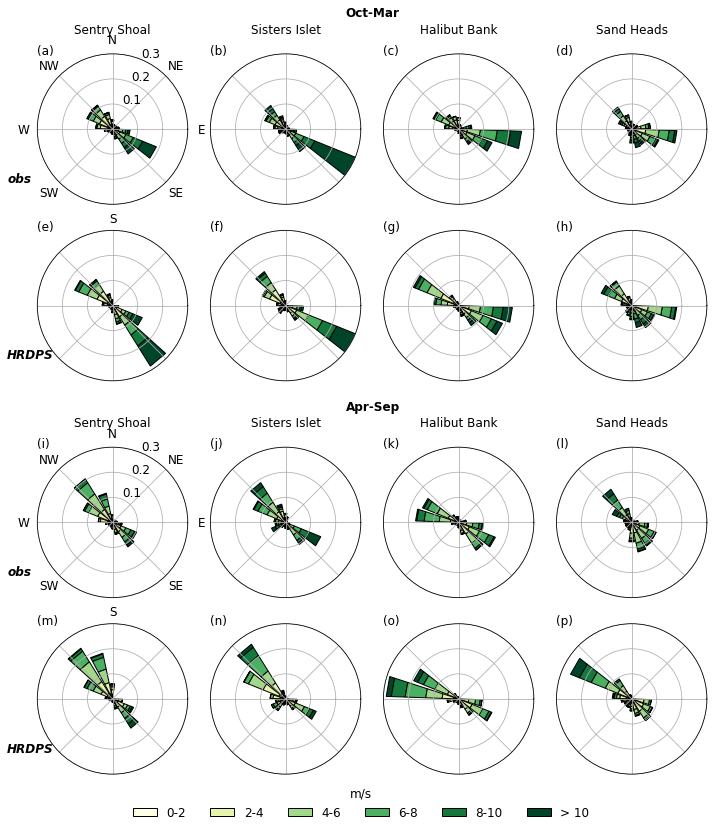

In [6]:
# Make figure
subplot_kw, gridspec_kw = {'axes_class': WindroseAxes}, {'wspace': 0.15, 'hspace': 0.15}
fig, axs = plt.subplots(4, 4, figsize=(12, 14), subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)

# Loop through stations and seasons
keylist, seasonlist = np.meshgrid(keys, ['Oct-Mar', 'Apr-Sep'])
for row, key, season in zip(axs, keylist.ravel(), seasonlist.ravel()):
    for ax, station in zip(row, stations):

        # Plot wind data
        tindex = np.array([3 < t.month < 10 for t in data[station][key]['time']])
        if season == 'Oct-Mar': tindex = ~tindex
        wspd, wdir = [data[station][key][var][tindex] for var in ('wspd', 'wdir')]
        ax.bar(
            wdir, wspd, bins=range(0, 11, 2), normed=True, nsector=18,
            opening=0.8, edgecolor='k', cmap=plt.get_cmap('YlGn'),
        )

        # Formatting axis
        ax.set_ylim([0, 30])
        ax.yaxis.set_ticks([10, 20, 30])
        ax.yaxis.set_ticklabels('')
        ax.xaxis.set_ticklabels('')
        if key == 'obs':
            ax.set_title(station, fontsize=12, y=1.1)
            if station == 'Sentry Shoal':
                ax.xaxis.set_ticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
                ax.yaxis.set_ticklabels([0.1, 0.2, 0.3])
                ax.text(2.05, 1.25, season, transform=ax.transAxes, fontdict={'weight': 'bold'})
        else:
            pos = ax.get_position()
            ax.set_position([pos.x0, pos.y0+0.02, pos.width, pos.height])
        if station == 'Sentry Shoal':
            ax.text(-0.2, 0.15, key, transform=ax.transAxes, fontdict={'style': 'italic', 'weight': 'bold'})

# Add legend and panel labels
# (manually get legend handles, since WindroseAxes.bar returns None)
handles, labels = ax.get_children()[:6], ['0-2', '2-4', '4-6', '6-8', '8-10', '> 10']
fig.legend(handles=handles, labels=labels, title='m/s', ncol=6, frameon=False, loc=8, bbox_to_anchor=(0.5, 0.1))
for k, ax in enumerate(axs.ravel()):
    ax.text(0, 1, f'({chr(97+k)})', transform=ax.transAxes)